### Stock Forecaster

In [1]:
from lib.forecast import StockForecaster
import pandas as pd

In [2]:
sf = StockForecaster()
sf.load()
sf.normalize_data()
sf.create_model()

#### Train Model

In [3]:
loss_data = sf.train()
plt.plot(loss_data)

Epoch: 0, train loss: 0.28660711646080017, test loss: 0.5410386323928833
Epoch: 100, train loss: 0.0681733638048172, test loss: 0.09672065079212189
Epoch: 200, train loss: 0.018502306193113327, test loss: 0.0067749242298305035
Epoch: 300, train loss: 0.004741736687719822, test loss: 0.011012337170541286
Epoch: 400, train loss: 0.0033315024338662624, test loss: 0.008267279714345932
Epoch: 500, train loss: 0.0027595616411417723, test loss: 0.005941763520240784
Epoch: 600, train loss: 0.0026207014452666044, test loss: 0.005127543117851019
Epoch: 700, train loss: 0.0025744917802512646, test loss: 0.00501001812517643
Epoch: 800, train loss: 0.002536060754209757, test loss: 0.004958056379109621
Epoch: 900, train loss: 0.0024926539044827223, test loss: 0.004887305665761232


#### Validate

In [4]:
train_predict = sf.lstm(sf.X_test_tensors) 
data_predict = sf.mm.inverse_transform(train_predict.data.numpy())

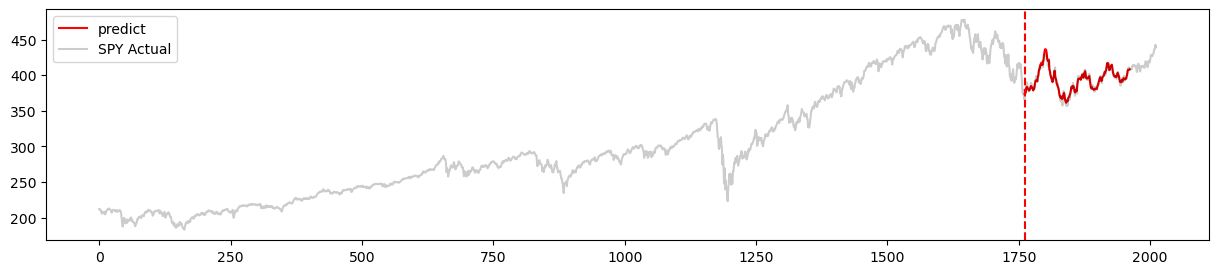

In [6]:
import matplotlib.pyplot as plt

dp = [None] * (sf.train_samples - 50)
dp.extend(data_predict[:,0])
plt.figure(figsize=(15,3)) #plotting
plt.plot(dp, "r", label="predict")
plt.plot(sf.mm.inverse_transform(sf.y_train), "k", label="SPY Actual", alpha=0.2)

plt.axvline(x=sf.train_samples-50, c='r', linestyle='--') # size of the training set

plt.legend()
plt.show()

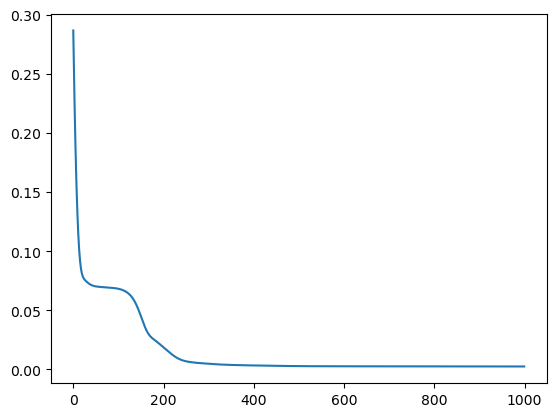